In [1]:
import gc
gc.collect()

232

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
print("Number of available GPU's: ", len(tf.config.experimental.list_physical_devices("GPU")))

Number of available GPU's:  0


In [5]:
import os
if "CNN" in os.path.abspath(os.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.curdir)
BASE_DIR

'D:\\TheCompleteML\\projects'

In [7]:
data_dir = os.path.join(BASE_DIR, "datasets", "classification", "flowers")

In [8]:
data_dirs = [os.path.join(data_dir, dir_) for dir_ in os.listdir(data_dir) if "processed" not in dir_]
data_dirs

['D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\daisy',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\dandelion',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\rose',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\sunflower',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\tulip']

## Preprocessing

In [25]:
import random
from skimage import io

class loading_and_splitting:
    
    def __init__(self, data_dirs, dims, channels=3, target_dir=data_dir):
        self.total_images = 0
        self.minh = np.inf
        self.minw = np.inf
        self.dims = dims
        self.channels = channels
        self.target_dir = target_dir
        self.data_dirs = data_dirs
        self.class_map = {k:v.split("\\")[-1] for k, v in enumerate(data_dirs)}
        
        self.header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        self.sample_list = [random.sample(range(len(os.listdir(path))), 
                                          len(os.listdir(path))) for path in data_dirs]
        for item in self.sample_list:
            self.total_images += len(item)
        self.generate_samples()
        self.max_train_instance = len(self.train_seq)
        self.max_valid_instance = len(self.valid_seq)
        self.max_test_instance = len(self.test_seq)
    
    def generate_csvs(self):
        header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        for set_ in ["train", "valid", "test"]:
            with open(os.path.join(self.target_dir, f"{set_}.csv"), "w") as f:
                df = pd.DataFrame(list(), columns=header_list)
                df.to_csv(f, index=False)
                
    def generate_samples(self):
        self.sample_seq = random.sample(range(self.total_images), self.total_images)
        self.train_seq = self.sample_seq[:int(len(self.sample_seq)*0.8)]
        self.valid_seq = self.sample_seq[int(len(self.sample_seq)*0.8):int(len(self.sample_seq)*0.9)]
        self.test_seq = self.sample_seq[int(len(self.sample_seq)*0.9):]
    
    def crop_image(self, image):
        h, w, d = image.shape
        if h >= self.minh and w >= self.minw:
            image = image[int(h/2)-64:int(h/2)+64, 
                          int(w/2)-64:int(w/2)+64, 
                          :]
            return image
    
    def crop_or_pad(self, image):
        image = tf.image.resize_with_crop_or_pad(image, self.dims[0], self.dims[0])
        return image.numpy()
    
    def shuffle_and_save(self):
        empty = []
        train = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        valid = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        test = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        count = 0
        while len(empty) != len(self.data_dirs):
            sel_dir = np.random.randint(0, len(self.data_dirs))
            if sel_dir in empty: continue
            dir_ = self.data_dirs[sel_dir]
            if not self.sample_list[sel_dir]:
                empty.append(sel_dir)
            else:
                count += 1
                print(f"Processing: {count}")
                sel_image = self.sample_list[sel_dir].pop()
                image = io.imread(os.path.join(dir_, os.listdir(dir_)[sel_image]))
                
                h, w, d = image.shape
                if h < self.minh: self.minh = h
                if w < self.minw: self.minw = w
                if self.minh < self.dims[0]: self.minh = self.dims[0]
                if self.minw < self.dims[1]: self.minw = self.dims[1]
                
                # image = self.crop_image(image)
                image = self.crop_or_pad(image)
                
                if not isinstance(image, np.ndarray): continue
                if sel_image in self.train_seq: 
                    train = np.append(train, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.valid_seq: 
                    valid = np.append(valid, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.test_seq: 
                    test = np.append(test, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
        
        train = train[1:, :]
        valid = valid[1:, :]
        test = test[1:, :]
        
        for prefix, arr in zip(["train", "valid", "test"], [train, valid, test]):
            self.split_and_save(arr, os.path.join(self.target_dir, "processed", prefix), prefix)
        
    def split_and_save(self, arr, target_dir, prefix, split_count=10):
        os.makedirs(target_dir, exist_ok=True)
        for i in range(split_count):
            df = pd.DataFrame(arr[i*int(arr.shape[0]//split_count):(i+1)*int(arr.shape[0]//split_count), :], 
                             columns=self.header_list)
            df.to_csv(os.path.join(target_dir, "{}_{}.csv".format(prefix, i+1)), index=False)

In [26]:
dims = (150, 150)
channels = 3
n_features = dims[0] * dims[1] * channels
ls = loading_and_splitting(data_dirs=data_dirs, dims=dims, channels=channels, target_dir=data_dir)
class_map = ls.class_map
max_train_instance = ls.max_train_instance
max_valid_instance = ls.max_valid_instance
max_test_instance = ls.max_test_instance
class_map
# ls.shuffle_and_save()

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [27]:
max_train_instance, max_valid_instance, max_test_instance

(3453, 432, 432)

In [11]:
set_dir = os.path.join(data_dir, "processed")
train_paths = [f"{os.path.join(set_dir, 'train')}\\{item}" for item in os.listdir(os.path.join(set_dir, "train"))]
valid_paths = [f"{os.path.join(set_dir, 'valid')}\\{item}" for item in os.listdir(os.path.join(set_dir, "valid"))]
test_paths = [f"{os.path.join(set_dir, 'test')}\\{item}" for item in os.listdir(os.path.join(set_dir, "test"))]

In [12]:
data_augmentation = tf.keras.Sequential([keras.layers.RandomFlip("horizontal_and_vertical"), 
                                         keras.layers.RandomRotation(0.2),
                                         keras.layers.RandomContrast(0.5),
                                         keras.layers.RandomZoom((-0.3, 0.3), (-0.3, 0.3))
                                         ])

def preprocess(line, augmentation=False):
    defs = [tf.constant([], dtype = tf.float32)] * (n_features + 1)
    xy = tf.io.decode_csv(line, record_defaults=defs)
    X = tf.stack(xy[:-1])
    y = tf.stack(xy[-1:])
    
    # prcessing steps
    X = tf.divide(X, 255)
    X = tf.reshape(X, [dims[0], dims[1], channels])
    if augmnentation:
        X = data_augmentation(X)
        X = tf.image.rot90(X)
        X = tf.image.random_brightness(X, 0.2)
    
    return X, y


def preprocess_test(X):
    # prcessing steps
    
    X = tf.image.resize_with_crop_or_pad(X, 150 ,150)
    X = data_augmentation(X)
    X = tf.image.rot90(X)
    X = tf.image.random_brightness(X, 0.2)
    X = tf.divide(X, 255)
    
    return X

In [14]:
from functools import partial

def read_csv_pipeline(paths, 
                      n_readers, 
                      shuffle_buffer_size, 
                      n_read_threds, 
                      n_parse_threads, 
                      batch_size, 
                      augmentation=False):
    
    filepaths = tf.data.Dataset.list_files(paths, seed=42)
    dataset = filepaths.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    if augmentation: dataset = dataset.repeat()
    dataset = dataset.map(partial(preprocess, augmentation=augmentation), num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

In [15]:
n_readers = 5
shuffle_buffer_size = 400
n_read_threads = None
n_parse_threads = 5
batch_size = 32

train_set = read_csv_pipeline(train_paths, n_readers, 
                              n_repeat, shuffle_buffer_size, 
                              n_read_threads, n_parse_threads, 
                              batch_size, 
                              augmentation=True)

valid_set = read_csv_pipeline(valid_paths, n_readers, 
                              n_repeat, shuffle_buffer_size, 
                              n_read_threads, n_parse_threads, 
                              batch_size, 
                              augmentation=False)

test_set = read_csv_pipeline(test_paths, n_readers, 
                              n_repeat, shuffle_buffer_size, 
                              n_read_threads, n_parse_threads, 
                              batch_size, 
                              augmentation=False)

### Model Training

In [16]:
class ResidualLayer(keras.layers.Layer):
    
    def __init__(self, fm, strides=1, ksize=3, padding="same", activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.fm = fm
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
        self.activation = keras.activations.get(activation)
        self.normalization = keras.layers.BatchNormalization()
        self.mainc_layers = [keras.layers.Conv2D(self.fm, 
                                                 kernel_size=self.ksize, 
                                                 strides=self.strides, 
                                                 padding=self.padding, 
                                                 use_bias=False),
                            self.normalization, 
                            self.activation,
                            keras.layers.Conv2D(self.fm, 
                                                kernel_size=self.ksize, 
                                                strides=1, 
                                                padding=self.padding, 
                                                use_bias=False),
                            self.normalization]
        self.skipc_layers = []
        if strides > 1:
            self.skipc_layers = [keras.layers.Conv2D(self.fm, 
                                                     kernel_size=1, 
                                                     strides=self.strides, 
                                                     padding=self.padding,
                                                     use_bias=False),
                                self.normalization]
    def get_config(self):
        config = super().get_config()
        config.update({"fm": self.fm,
                        "ksize": self.ksize,
                        "strides": self.strides,
                        "padding": self.padding,
                        "activation": self.activation
                        })
        return config
    
    def call(self, inputs):
        z = inputs
        for layer in self.mainc_layers:
            z = layer(z)
        skip_z = inputs
        for layer in self.skipc_layers:
            skip_z = layer(skip_z)
        return self.activation(z+skip_z)

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    changes: dense layer size increased to 128
             he_normal initilizatin is implemented
             optimizer is changed from nadam to momentum with decay rate
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [34]:
model, callbacks = cnn_mp_r3_de_v2()

In [35]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 134s 1s/step - loss: nan - sparse_categorical_accuracy: 0.1814 - val_loss: nan - val_sparse_categorical_accuracy: 0.1719
Epoch 2/5
97/97 [==============================] - 130s 1s/step - loss: nan - sparse_categorical_accuracy: 0.1843 - val_loss: nan - val_sparse_categorical_accuracy: 0.1771
Epoch 3/5
97/97 [==============================] - 130s 1s/step - loss: nan - sparse_categorical_accuracy: 0.1775 - val_loss: nan - val_sparse_categorical_accuracy: 0.1719
Epoch 4/5
97/97 [==============================] - 132s 1s/step - loss: nan - sparse_categorical_accuracy: 0.1611 - val_loss: nan - val_sparse_categorical_accuracy: 0.1667
Epoch 5/5
97/97 [==============================] - 130s 1s/step - loss: nan - sparse_categorical_accuracy: 0.1817 - val_loss: nan - val_sparse_categorical_accuracy: 0.1693


### Training with different optimizers

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
   
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
#     optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [37]:
model, callbacks = cnn_mp_r3_de_v2()

In [38]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 138s 1s/step - loss: 1.4514 - sparse_categorical_accuracy: 0.3553 - val_loss: 1.2857 - val_sparse_categorical_accuracy: 0.3854
Epoch 2/5
97/97 [==============================] - 137s 1s/step - loss: 1.3074 - sparse_categorical_accuracy: 0.4446 - val_loss: 1.3003 - val_sparse_categorical_accuracy: 0.4089
Epoch 3/5
97/97 [==============================] - 134s 1s/step - loss: 1.2394 - sparse_categorical_accuracy: 0.4726 - val_loss: 1.1672 - val_sparse_categorical_accuracy: 0.5469
Epoch 4/5
97/97 [==============================] - 133s 1s/step - loss: 1.2192 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.1271 - val_sparse_categorical_accuracy: 0.5807
Epoch 5/5
97/97 [==============================] - 132s 1s/step - loss: 1.1396 - sparse_categorical_accuracy: 0.5467 - val_loss: 1.0547 - val_sparse_categorical_accuracy: 0.5781


In [39]:
 keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
  

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [40]:
model, callbacks = cnn_mp_r3_de_v2()

In [41]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 136s 1s/step - loss: 1.6377 - sparse_categorical_accuracy: 0.2574 - val_loss: 1.6638 - val_sparse_categorical_accuracy: 0.1745
Epoch 2/5
97/97 [==============================] - 130s 1s/step - loss: 1.6141 - sparse_categorical_accuracy: 0.2378 - val_loss: 1.6102 - val_sparse_categorical_accuracy: 0.2474
Epoch 3/5
97/97 [==============================] - 134s 1s/step - loss: 1.6052 - sparse_categorical_accuracy: 0.2239 - val_loss: 1.5973 - val_sparse_categorical_accuracy: 0.2474
Epoch 4/5
97/97 [==============================] - 133s 1s/step - loss: 1.5893 - sparse_categorical_accuracy: 0.2610 - val_loss: 1.5938 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/5
54/97 [===============>..............] - ETA: 43s - loss: 1.6123 - sparse_categorical_accuracy: 0.1921

KeyboardInterrupt: 

In [42]:
 keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [43]:
model, callbacks = cnn_mp_r3_de_v2()

In [44]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 136s 1s/step - loss: 1.4953 - sparse_categorical_accuracy: 0.3283 - val_loss: 1.3413 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/5
97/97 [==============================] - 133s 1s/step - loss: 1.3042 - sparse_categorical_accuracy: 0.4288 - val_loss: 1.2589 - val_sparse_categorical_accuracy: 0.4635
Epoch 3/5
97/97 [==============================] - 131s 1s/step - loss: 1.2657 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.1900 - val_sparse_categorical_accuracy: 0.4948
Epoch 4/5
97/97 [==============================] - 134s 1s/step - loss: 1.2398 - sparse_categorical_accuracy: 0.4771 - val_loss: 1.1691 - val_sparse_categorical_accuracy: 0.4896
Epoch 5/5
97/97 [==============================] - 131s 1s/step - loss: 1.2400 - sparse_categorical_accuracy: 0.4733 - val_loss: 1.1564 - val_sparse_categorical_accuracy: 0.5130


In [45]:
 keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
  
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [46]:
model, callbacks = cnn_mp_r3_de_v2()

In [47]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 133s 1s/step - loss: 1.5109 - sparse_categorical_accuracy: 0.3070 - val_loss: 1.2921 - val_sparse_categorical_accuracy: 0.3828
Epoch 2/5
97/97 [==============================] - 128s 1s/step - loss: 1.3329 - sparse_categorical_accuracy: 0.4162 - val_loss: 1.2634 - val_sparse_categorical_accuracy: 0.4896
Epoch 3/5
97/97 [==============================] - 131s 1s/step - loss: 1.3028 - sparse_categorical_accuracy: 0.4265 - val_loss: 1.2135 - val_sparse_categorical_accuracy: 0.4453
Epoch 4/5
97/97 [==============================] - 130s 1s/step - loss: 1.2508 - sparse_categorical_accuracy: 0.4671 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.4870
Epoch 5/5
97/97 [==============================] - 130s 1s/step - loss: 1.1902 - sparse_categorical_accuracy: 0.5061 - val_loss: 1.1198 - val_sparse_categorical_accuracy: 0.5312


In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    changes: dense layer size increased to 128
             he_normal initilizatin is implemented
             optimizer is changed from nadam to momentum with decay rate
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="adam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [51]:
model, callbacks = cnn_mp_r3_de_v2()

In [52]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 133s 1s/step - loss: 1.4417 - sparse_categorical_accuracy: 0.3531 - val_loss: 1.2625 - val_sparse_categorical_accuracy: 0.4245
Epoch 2/5
97/97 [==============================] - 129s 1s/step - loss: 1.2789 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.1716 - val_sparse_categorical_accuracy: 0.4609
Epoch 3/5
97/97 [==============================] - 129s 1s/step - loss: 1.2445 - sparse_categorical_accuracy: 0.4768 - val_loss: 1.1711 - val_sparse_categorical_accuracy: 0.5052
Epoch 4/5
97/97 [==============================] - 132s 1s/step - loss: 1.2316 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.1175 - val_sparse_categorical_accuracy: 0.5469
Epoch 5/5
97/97 [==============================] - 130s 1s/step - loss: 1.1931 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.5443


In [56]:
 keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    changes: dense layer size increased to 128
             he_normal initilizatin is implemented
             optimizer is changed from nadam to momentum with decay rate
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [57]:
model, callbacks = cnn_mp_r3_de_v2()

In [58]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 145s 1s/step - loss: 1.4900 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.2772 - val_sparse_categorical_accuracy: 0.4219
Epoch 2/5
97/97 [==============================] - 139s 1s/step - loss: 1.3380 - sparse_categorical_accuracy: 0.4214 - val_loss: 1.2705 - val_sparse_categorical_accuracy: 0.3854
Epoch 3/5
97/97 [==============================] - 139s 1s/step - loss: 1.2860 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.2057 - val_sparse_categorical_accuracy: 0.5208
Epoch 4/5
97/97 [==============================] - 135s 1s/step - loss: 1.2318 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.5260
Epoch 5/5
97/97 [==============================] - 141s 1s/step - loss: 1.2226 - sparse_categorical_accuracy: 0.5084 - val_loss: 1.1106 - val_sparse_categorical_accuracy: 0.5755


##### Observations

Above results clearly concludes that nadam and RMSprop optimizer outperforms all others. Next, we can choose nadam.RMSprop and experiments with some other variables with model

## Different Model Architecture

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r4_de():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    changes copare to cnn_mp_r3_de:
            extra cnn with kenel size of 512
            dense layer size increased to 128
            he_normal initilizatin is implemented
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(512, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
        
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r4_de.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [63]:
model, callbacks = cnn_mp_r4_de()

In [64]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 155s 2s/step - loss: 1.6924 - sparse_categorical_accuracy: 0.3254 - val_loss: 1.3802 - val_sparse_categorical_accuracy: 0.3776
Epoch 2/5
97/97 [==============================] - 151s 2s/step - loss: 1.3186 - sparse_categorical_accuracy: 0.4166 - val_loss: 1.2118 - val_sparse_categorical_accuracy: 0.4401
Epoch 3/5
97/97 [==============================] - 156s 2s/step - loss: 1.2511 - sparse_categorical_accuracy: 0.4720 - val_loss: 1.1742 - val_sparse_categorical_accuracy: 0.5104
Epoch 4/5
97/97 [==============================] - 155s 2s/step - loss: 1.2143 - sparse_categorical_accuracy: 0.4932 - val_loss: 1.1436 - val_sparse_categorical_accuracy: 0.5052
Epoch 5/5
97/97 [==============================] - 150s 2s/step - loss: 1.1657 - sparse_categorical_accuracy: 0.5245 - val_loss: 1.0710 - val_sparse_categorical_accuracy: 0.5443


In [71]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de_v2():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    changes:
            dense layer size increased to 128
            he_normal initilizatin is implemented
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels],
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False,
                                  kernel_initializer="he_normal",
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
        
    model_target = os.path.join(BASE_DIR, "models", "cnn_mp_r3_de_v2.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [72]:
model, callbacks = cnn_mp_r3_de_v2()

In [68]:
history = model.fit(train_set, 
                    epochs=5, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/5
97/97 [==============================] - 144s 1s/step - loss: 1.7884 - sparse_categorical_accuracy: 0.3541 - val_loss: 1.2552 - val_sparse_categorical_accuracy: 0.4531
Epoch 2/5
97/97 [==============================] - 139s 1s/step - loss: 1.2972 - sparse_categorical_accuracy: 0.4443 - val_loss: 1.1778 - val_sparse_categorical_accuracy: 0.4948
Epoch 3/5
97/97 [==============================] - 138s 1s/step - loss: 1.2268 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.1302 - val_sparse_categorical_accuracy: 0.5495
Epoch 4/5
97/97 [==============================] - 141s 1s/step - loss: 1.1826 - sparse_categorical_accuracy: 0.4971 - val_loss: 1.0885 - val_sparse_categorical_accuracy: 0.5521
Epoch 5/5
97/97 [==============================] - 143s 1s/step - loss: 1.1258 - sparse_categorical_accuracy: 0.5506 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.6250


In [76]:
history = model.fit(train_set, 
                    epochs=25, 
                    steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                    validation_data=valid_set, 
                    validation_steps=int(0.9 * max_valid_instance / batch_size),
                    callbacks=callbacks)

Epoch 1/25
97/97 [==============================] - 147s 2s/step - loss: 1.7125 - sparse_categorical_accuracy: 0.3576 - val_loss: 1.2798 - val_sparse_categorical_accuracy: 0.4167
Epoch 2/25
97/97 [==============================] - 141s 1s/step - loss: 1.3085 - sparse_categorical_accuracy: 0.4391 - val_loss: 1.2109 - val_sparse_categorical_accuracy: 0.4740
Epoch 3/25
97/97 [==============================] - 141s 1s/step - loss: 1.2280 - sparse_categorical_accuracy: 0.4742 - val_loss: 1.2233 - val_sparse_categorical_accuracy: 0.5078
Epoch 4/25
97/97 [==============================] - 134s 1s/step - loss: 1.2010 - sparse_categorical_accuracy: 0.5064 - val_loss: 1.0990 - val_sparse_categorical_accuracy: 0.5677
Epoch 5/25
97/97 [==============================] - 136s 1s/step - loss: 1.1398 - sparse_categorical_accuracy: 0.5370 - val_loss: 1.0768 - val_sparse_categorical_accuracy: 0.5573
Epoch 6/25
97/97 [==============================] - 135s 1s/step - loss: 1.1281 - sparse_categorical_accu

### Experiment with Learning Rate

In [77]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, lr*self.factor)
        
def find_learnig_rate(model, train_set, epochs=1, batch_size=32, min_rate=1e-5, max_rate=10):
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.learning_rate)
    iterations = np.math.ceil(0.9*max_train_instance / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(train_set, 
                        epochs=epochs, 
                        steps_per_epoch=int(0.9 * max_train_instance / batch_size),
                        batch_size=batch_size, 
                        callbacks=[exp_lr])
    model.set_weights(init_weights)
    K.set_value(model.optimizer.learning_rate, init_lr)
    return exp_lr.rates, exp_lr.losses

def plot_rates_vs_losses(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [78]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

97/97 [==============================] - 98s 1s/step - loss: nan - sparse_categorical_accuracy: 0.2342         


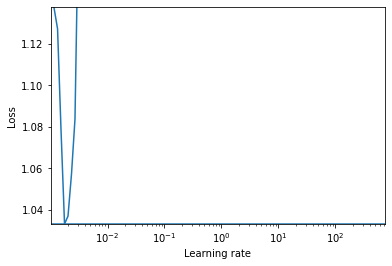

In [79]:
batch_size = 32
rates, losses = find_learnig_rate(model, train_set, epochs=1, batch_size=batch_size)
plot_rates_vs_losses(rates, losses)